In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings

warnings.filterwarnings("ignore")

import pathlib
import os
from scipy.stats import pearsonr
import seaborn as sb
from preprocessing_sequencing import preprocess_sequences as ps
from matplotlib import rcParams
import statistics
from final_processing import final_processing_functions as fpf
import ast
from allensdk.core.mouse_connectivity_cache import MouseConnectivityCache

%matplotlib inline

In [30]:
parameters_path = pathlib.Path("/camp/lab/znamenskiyp/home/shared/projects/turnerb_A1_MAPseq/FIAA55.4d/Sequencing")

In [31]:
parameters = ps.load_parameters(directory=str(parameters_path))


Run barcode matching job

In [4]:
ps.barcode_matching(
    sorting_directory=str(parameters_path / "final_processed_sequences"),
    use_slurm=False,)
    #slurm_folder="/camp/home/turnerb/slurm_logs",
#)

reading barcode file neuron_counts_BC186.csv
reading barcode file neuron_counts_BC264.csv
reading barcode file neuron_counts_BC175.csv
reading barcode file neuron_counts_BC170.csv
reading barcode file neuron_counts_BC187.csv
reading barcode file neuron_counts_BC107.csv


reading barcode file neuron_counts_BC234.csv
reading barcode file neuron_counts_BC242.csv
reading barcode file neuron_counts_BC166.csv
reading barcode file neuron_counts_BC203.csv
reading barcode file neuron_counts_BC104.csv
reading barcode file neuron_counts_BC221.csv
reading barcode file neuron_counts_BC110.csv
reading barcode file neuron_counts_BC200.csv
reading barcode file neuron_counts_BC199.csv
reading barcode file neuron_counts_BC100.csv
reading barcode file neuron_counts_BC157.csv
reading barcode file neuron_counts_BC218.csv
reading barcode file neuron_counts_BC115.csv
reading barcode file neuron_counts_BC269.csv
reading barcode file neuron_counts_BC270.csv
reading barcode file neuron_counts_BC171.csv
reading barcode file neuron_counts_BC236.csv
reading barcode file neuron_counts_BC109.csv
reading barcode file neuron_counts_BC252.csv
reading barcode file neuron_counts_BC244.csv
reading barcode file neuron_counts_BC239.csv
reading barcode file neuron_counts_BC235.csv
reading ba

Set minimum count thresholds for analysis

In [32]:
barcodes_across_sample = pd.read_pickle(
    str(parameters_path / "final_processed_sequences/barcodes_across_sample.pkl")
)

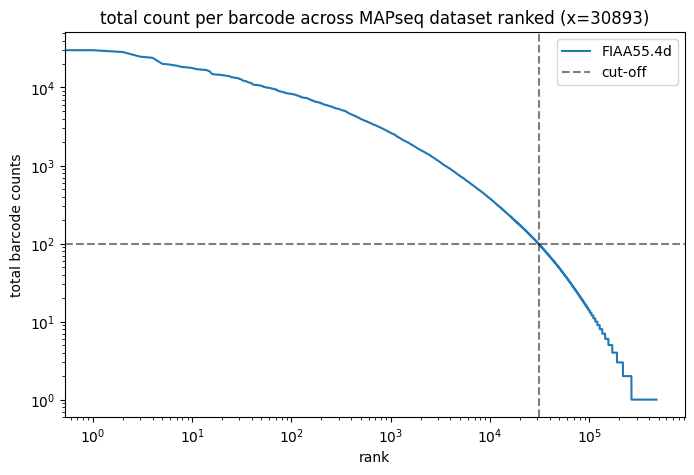

In [33]:
# determine cut-off for total counts for barcode across dataset
max_y = 100
rcParams["figure.figsize"] = 8, 5
interpolate_on_x = len(np.flip(np.sort(barcodes_across_sample.sum(axis=1)))) - len(
    np.flip(np.sort(barcodes_across_sample.sum(axis=1)))[
        np.flip(np.sort(barcodes_across_sample.sum(axis=1))) < max_y
    ]
)
plt.loglog(np.flip(np.sort(barcodes_across_sample.sum(axis=1))), label=parameters["MOUSE"])
plt.xlabel("rank")
plt.ylabel("total barcode counts")
plt.axhline(y=max_y, linestyle="dashed", color="Black", label="cut-off", alpha=0.5)
plt.axvline(x=interpolate_on_x, linestyle="dashed", color="Black", alpha=0.5)
plt.title(
    f"total count per barcode across MAPseq dataset ranked (x={interpolate_on_x})"
)
plt.legend()

In [34]:
filtered_barcodes = barcodes_across_sample[barcodes_across_sample.sum(axis=1) >= max_y]

Text(0.5, 1.0, 'barcode umi counts in negative controls \n n = 314')

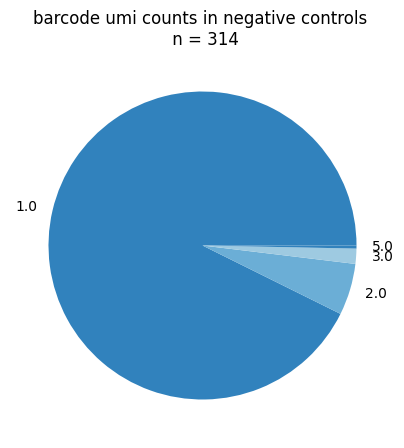

In [35]:
negative_samples = parameters['negative_control_samples']
rcParams["figure.figsize"] = 5, 5
cmap = plt.get_cmap("tab20c")

negs = filtered_barcodes[negative_samples].melt(
    var_name="samples", value_name="barcode_counts"
)
colours_picking = sb.color_palette("tab20c")[0:3]
plt.pie(
    negs[negs["barcode_counts"] > 0]["barcode_counts"].value_counts(),
    labels=negs[negs["barcode_counts"] > 0]["barcode_counts"]
    .value_counts()
    .index.values.tolist(),
    colors=colours_picking,
)
plt.title(
    f"barcode umi counts in negative controls \n n = {len(negs[negs.barcode_counts>0])}"
)

In [36]:
min_barcode_count_per_sample = 2
for x in range(1, min_barcode_count_per_sample):
    filtered_barcodes = filtered_barcodes.replace(x, 0)

In [ ]:
# #rename tubes, so sample names in sequencing data is the same as tube names
#filtered_barcodes = fpf.rename_tubes(barcode_table =filtered_barcodes, parameters_path= parameters_path)

Normalise based on spike in RNA levels

In [37]:

sorting_dir = parameters_path / "final_processed_sequences"
# spike-in normalisation, generate table of spike counts per sample
spike_counts = pd.DataFrame(columns=["sample", "spike_count"])
for sample in os.listdir(sorting_dir):
    if sample.startswith("spike_counts"):
        sample_name = sample.split("spike_counts_", 1)
        sample_name = sample_name[1][: -len(".csv")]
        sample_num = float(sample_name[2:])
        sample_reading = pd.read_csv(sorting_dir / sample)
        sample_reading["counts"] = sample_reading["counts"].astype("int")
        sum_counts = sample_reading["counts"].sum()
        new_row = pd.DataFrame(
            {"sample": sample_num, "spike_count": sum_counts}, index=[0]
        )
        spike_counts = pd.concat([spike_counts, new_row])

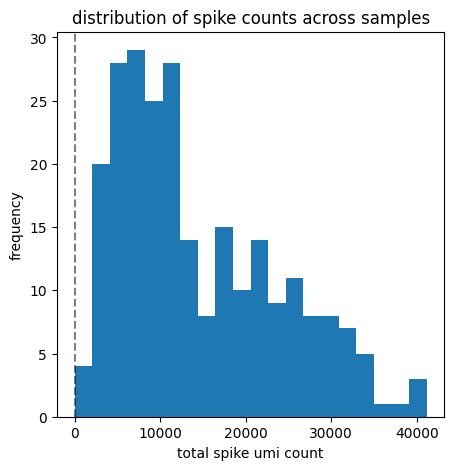

In [38]:
# plot the distribtution of spike-in reads and decide cut-off threshold
rcParams["figure.figsize"] = 5, 5
plt.hist(spike_counts["spike_count"], bins=20)
plt.xlabel("total spike umi count")
plt.ylabel("frequency")
plt.title("distribution of spike counts across samples")
plt.axvline(x=50, color="black", linestyle="dashed", label="cut-off", alpha=0.5)

In [39]:
# remove spikes that are below certain threshold, then normalise total counts in each sample by relative spike-count

spike_cutoff = 10
spike_thresh = list(spike_counts[spike_counts["spike_count"] < spike_cutoff]["sample"])
filtered_barcodes_QC = filtered_barcodes.drop((spike_thresh), axis=1)
spikes_thresholded = spike_counts[spike_counts["spike_count"] > spike_cutoff]
median_spike = statistics.median(spikes_thresholded["spike_count"].to_list())
spikes_thresholded["normalisation_factor"] = (
    spikes_thresholded["spike_count"] / median_spike
)
filtered_barcodes_spike_normalised = filtered_barcodes_QC.copy()
for i, row in spikes_thresholded.iterrows():
    if row["sample"] in filtered_barcodes_spike_normalised.columns:
        filtered_barcodes_spike_normalised[row["sample"]] = (
            filtered_barcodes_spike_normalised[row["sample"]]
            / row["normalisation_factor"]
        )

In [40]:
#rename tubes, so sample names in sequencing data is the same as tube names
filtered_barcodes_spike_normalised = fpf.rename_tubes(barcode_table =filtered_barcodes_spike_normalised, parameters_path= parameters_path)

Now let's locate the soma

In [41]:
lcm_dir =parameters['lcm_directory']
ROI_3D = np.load(f"{lcm_dir}/ROI_3D_25.npy")
#remove barcodes only found less than two samples
filtered_barcodes_spike_normalised=filtered_barcodes_spike_normalised[filtered_barcodes_spike_normalised.astype(bool).sum(axis=1)>2]
adj_roi = fpf.find_adjacent_samples(ROI_array= ROI_3D, samples_to_look= filtered_barcodes_spike_normalised.columns, parameters_path=str(parameters_path))
# for key in list(adj_roi.keys()):
#     adj_roi[key] = [sample for sample in adj_roi[key] if sample not in failed_RT] #make sure we're not including the samples we removed 
# now set adjacent columns to zero
for i in np.unique(filtered_barcodes_spike_normalised.idxmax(axis=1)):
    to_rename = [col for col in adj_roi[i] if col in filtered_barcodes_spike_normalised.columns]
    filtered_barcodes_spike_normalised.loc[filtered_barcodes_spike_normalised.idxmax(axis=1)==i, to_rename] = 0

In [42]:
# what does the distribution max/2nd max look like?
filtered_barcodes_abundance = pd.DataFrame()
filtered_barcodes_abundance["highest"] = filtered_barcodes_spike_normalised.max(axis=1)
filtered_barcodes_abundance["second"] = (filtered_barcodes_spike_normalised.apply(lambda row: row.nlargest(2).values[-1], axis=1) )

filtered_barcodes_abundance["relative_to_max"] = np.log10(
    filtered_barcodes_abundance["highest"] / filtered_barcodes_abundance["second"])


Text(0.5, 0.98, 'Frequency distribution 1st / 2nd max counts of barcodes')

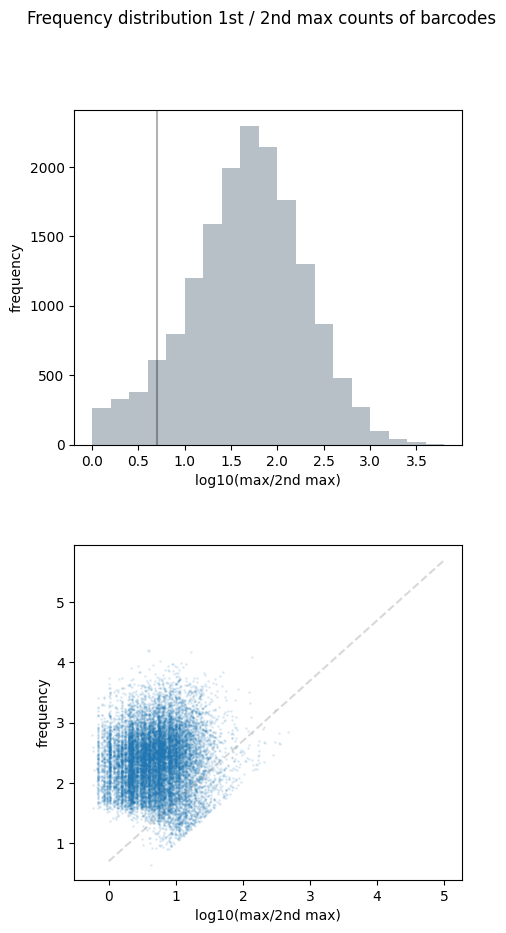

In [43]:
ratio_cut_off = 5
fig, ax = plt.subplots(2, figsize=(5, 10))
plt.subplots_adjust(hspace=0.3)
slope = 1
intercept = np.log10(ratio_cut_off)
x_vals = np.array((0, 5))
y_vals = intercept + slope * x_vals

ax[0].hist(filtered_barcodes_abundance["relative_to_max"], alpha=0.5,  color = 'slategray', bins=np.arange(0, 4, 0.2))
ax[0].axvline(np.log10(ratio_cut_off),color='black', linestyle='-', alpha = 0.3)
ax[0].set_xlabel('log10(max/2nd max)')
ax[0,].set_ylabel('frequency')

ax[1].scatter(
    x=np.log10(filtered_barcodes_abundance["second"]),
    y=np.log10(filtered_barcodes_abundance["highest"]),
    s=1,
    alpha=0.1,
)
ax[1].plot(
   x_vals, y_vals, "--", c="grey", label=f"x{ratio_cut_off} enrichment of soma", alpha=0.3
)
ax[1].set_xlabel('log10(max/2nd max)')
ax[1].set_ylabel('frequency')
plt.suptitle('Frequency distribution 1st / 2nd max counts of barcodes')

In [44]:
#set minimum soma to second max ratio and set the main projection target to be minimum 10 counts
soma_thresh = np.log10(ratio_cut_off)
filtered_soma_barcodes = filtered_barcodes_spike_normalised[
    (filtered_barcodes_abundance["relative_to_max"] > soma_thresh) & (filtered_barcodes_abundance["second"] >= 10)]

(array([531., 776., 441., 444., 190., 144.,  58.,  18.,   9.,   3.]),
 array([ 2. ,  4.6,  7.2,  9.8, 12.4, 15. , 17.6, 20.2, 22.8, 25.4, 28. ]),
 <BarContainer object of 10 artists>)

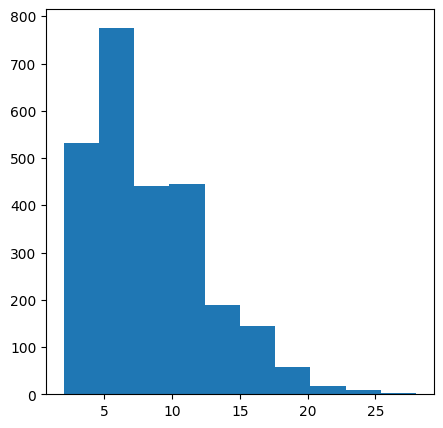

In [45]:
plt.hist(filtered_soma_barcodes.astype(bool).sum(axis=1))

Now let's select barcodes that have A1 as a source site

In [46]:
#from sample table, get main region
sample_vol_path = parameters['lcm_directory']+'/sample_vol_and_regions.pkl'
#fpf.get_main_region(sample_vol=sample_vol_path, parameters_path= str(parameters_path), use_slurm=True, slurm_folder="/camp/home/turnerb/slurm_logs", job_dependency=lrf_job)

In [47]:
sample_vol_and_regions =pd.read_pickle(pathlib.Path(parameters['lcm_directory'])/'sample_vol_and_regions.pkl')
AUDp_containing = sample_vol_and_regions[sample_vol_and_regions['main']=='AUDp']['ROI Number'].to_list()
filtered_soma_barcodes =filtered_soma_barcodes[filtered_soma_barcodes.idxmax(axis=1).isin(AUDp_containing)]

Let's now QC failed RNA extraction samples by comparing to anterograde tracing data

In [23]:

# #let's first compare allen tracing to identify samples that have failed RNA extraction
# allen_comp_table = fpf.compare_to_allen(barcode_table=filtered_soma_barcodes, parameters_path=str(parameters_path))
# #let's now remove any samples where the summed projection strength for allen anterograde tracing is >10, but the summed MAPseq count for those ROI's is zero
# mean_negative = allen_comp_table[allen_comp_table['Sample'].isin(parameters['negative_control_samples'])]['Mean_Allen'].mean()
# failed_RT = allen_comp_table[(allen_comp_table['Mean_Allen']>=mean_negative*10) & (allen_comp_table['MAPseq_counts']==0)]['Sample'].to_list()

# #and remove
# filtered_soma_barcodes.drop(columns=failed_RT, inplace=True)

Updated removal of failed RT -> all samples with no MAPseq counts removed

In [48]:
failed_RT = filtered_soma_barcodes.loc[:, (filtered_soma_barcodes == 0).all()].columns
filtered_soma_barcodes.drop(columns=failed_RT, inplace=True)

In [50]:
filtered_soma_barcodes.to_pickle(parameters_path/'A1_barcodes_thresholded_with_source.pkl')

In [51]:
AUDp_containing = [sample for sample in AUDp_containing if sample in filtered_soma_barcodes.columns]

In [52]:
#remove source samples for analysis
filtered_soma_barcodes.drop(columns=AUDp_containing, inplace=True)

In [29]:
filtered_soma_barcodes.to_pickle(parameters_path/'A1_barcodes_thresholded.pkl')